In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import os

In [11]:
# Define the path to the directory containing the CSV files
directory_path = './hite_items'

# Initialize an empty dictionary to store the DataFrames
dataframes_dict = {}

# Iterate over the files in the directory
for filename in os.listdir(directory_path):
    # Check if the file is a CSV file
    if filename.endswith('.csv'):
        # Create the full file path
        file_path = os.path.join(directory_path, filename)
        
        # Read the CSV file into a DataFrame
        df = pd.read_csv(file_path)
        
        # Use the filename (without extension) as the key
        key = os.path.splitext(filename)[0]
        
        # Store the DataFrame in the dictionary
        dataframes_dict[key] = df

In [12]:
dataframes_dict["Festplatte1080GB_SCSI-2-Fast"]

,date,net_sales,quantity
0,2000-01-17,76644.41,347
1,2000-02-28,71564.23,324
2,2000-03-13,70901.60,321
3,2000-04-13,70238.97,318
4,2000-05-31,62729.14,284
...,...,...,...
58,2005-07-13,64723.70,293
59,2005-08-11,69583.50,315
60,2005-09-13,81733.00,370
61,2005-10-14,68258.10,309


In [13]:
def merge_dataframes(keys, dataframes_dict):
    """
    Merge DataFrames based on the 'date' column and sum the values of other columns if dates are the same.
    
    Parameters:
    keys (list): List of keys (filenames without extension) to be merged.
    dataframes_dict (dict): Dictionary containing DataFrames.
    
    Returns:
    pd.DataFrame: Merged DataFrame.
    """
    # Ensure all selected DataFrames have 'date' as a datetime type column
    for key in keys:
        dataframes_dict[key]['date'] = pd.to_datetime(dataframes_dict[key]['date'])
    
    # Initialize the merged DataFrame with the first DataFrame in the list
    merged_df = dataframes_dict[keys[0]]
    
    # Iterate over the remaining DataFrames and merge them
    for key in keys[1:]:
        merged_df = pd.merge(merged_df, dataframes_dict[key], on='date', how='outer', suffixes=('', '_dup'))
        
        # Sum the columns with the same name
        for column in merged_df.columns:
            if '_dup' in column:
                original_column = column.replace('_dup', '')
                merged_df[original_column] = merged_df[original_column].fillna(0) + merged_df[column].fillna(0)
                merged_df.drop(column, axis=1, inplace=True)
    
    # Sort by date to maintain chronological order
    merged_df.sort_values(by='date', inplace=True)
    
    return merged_df

In [6]:
keys_to_merge = ["FlatscreenLE64P", "FlatscreenMS1775P", "FlatscreenMS1785P"]
merged_df = merge_dataframes(keys_to_merge, dataframes_dict)

In [7]:
merged_df.head()

,date,net_sales,quantity
0,2000-01-31,54057.18,50.0
1,2000-02-15,50776.01,47.0
2,2000-03-22,49972.90,46.0
3,2000-04-17,49851.04,46.0
4,2000-05-31,43233.25,40.0


In [16]:
# Convert 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'])

In [17]:
# Add columns for day of the month, day of the week, and month of the year
df['day_of_month'] = df['date'].dt.day
df['day_of_week'] = df['date'].dt.dayofweek  # Monday=0, Sunday=6
df['month_of_year'] = df['date'].dt.month

In [18]:
df.head()

,date,net_sales,quantity,day_of_month,day_of_week,month_of_year
0,2000-01-17,12347.83,339,17,0,1
1,2000-02-28,11582.92,318,28,0,2
2,2000-03-13,11473.65,315,13,0,3
3,2000-04-13,11250.73,312,13,3,4
4,2000-05-31,10125.95,278,31,2,5


In [20]:
df.shape

(64, 6)

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [23]:
# Prepare features and target
X = df[['day_of_month', 'day_of_week', 'month_of_year']]
y = df['quantity']
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [60]:

# Train the Decision Tree Regressor
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

# Print the first few predictions
print("Predictions:", y_pred)
print("Actual:", list(y_test))

Mean Squared Error: 10099.638461538461
R^2 Score: -0.036768923881708604
Predictions: [311.82 312.51 392.24 325.92 343.38 346.58 330.65 313.73 321.11 348.
 312.52 309.42 340.22]
Actual: [268, 312, 339, 303, 324, 308, 680, 356, 330, 357, 300, 308, 340]


In [61]:
model.feature_importances_

array([0.33941966, 0.20730911, 0.45327122])

In [62]:
model.feature_names_in_

array(['day_of_month', 'day_of_week', 'month_of_year'], dtype=object)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
52    268
58    312
0     339
44    303
5     324
36    308
16    680
12    356
25    330
61    357
56    300
9     308
40    340
Name: quantity, dtype: int64


<BarContainer object of 13 artists>

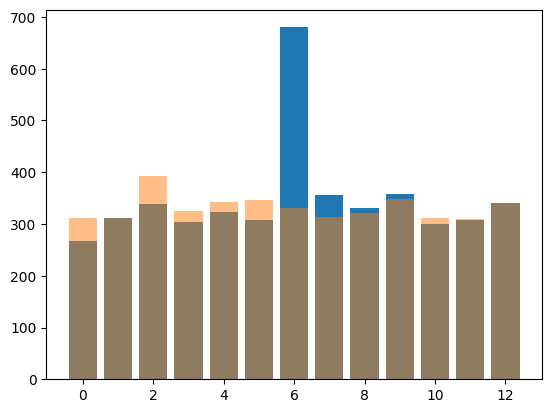

In [68]:
indexes = [i for i, _ in enumerate(y_test)]
plt.bar(indexes, y_test)
plt.bar(indexes, y_pred, alpha=0.5)

<BarContainer object of 51 artists>

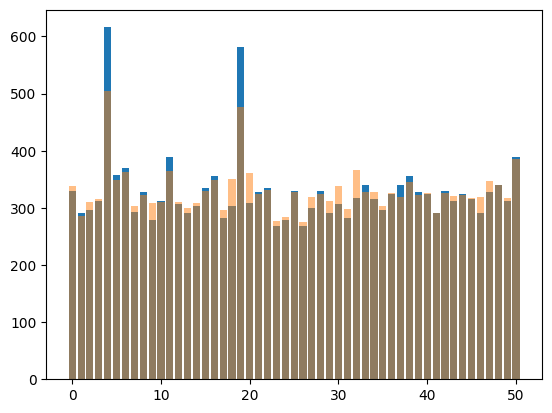

In [69]:
indexes = [i for i, _ in enumerate(y_train)]
plt.bar(indexes, y_train)
plt.bar(indexes, model.predict(X_train), alpha=0.5)